# ADWORDS - Projeto 2 [by Query Explorer](https://ga-dev-tools.appspot.com/query-explorer)

IF697 — Introdução à Ciência dos Dados

Prof. Dr. Luciano Barbosa

Alunos: Hywre Cesar & Rafael Albuquerque

Utilizando o pre processado pelo projeto 1, iremos usar regressões para predizer os valores dos anúncios do nosso dataset inicial.

In [3]:
import pandas as pd
from sklearn import preprocessing
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import optuna
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
plt.close("all")

## Importação do nosso dataset preprocessado

In [4]:
dataset = pd.read_csv("preprocessed_final_dataset.csv")
dataset.head()

,Unnamed: 0,dateHourMinute,adMatchedQuery,city,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,pageviews,timeOnPage,ctr,screenResolutionDist,adMatchedQueryLenDist,hasFarmaOnQuery
0,0,2019-01-15 07:53:00,farmácia são paulo olinda estoque,Recife,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,1.0,1.0,0.27,1.0,288.2,1.0,x-small,short,True
1,1,2019-01-15 07:54:00,farmacia independente olinda,Olinda,360x640,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,1.0,1.0,0.27,3.0,15.0,1.0,x-small,short,True
2,2,2019-01-15 08:12:00,vick baby rub comprar,Olinda,360x640,Chrome,Android,Samsung SM-G531H Galaxy Grand Prime,Google search: Other,Broad match,1.0,1.0,0.23,NaN,276.0,1.0,x-small,short,False
3,3,2019-01-15 08:50:00,lacday similar,Recife,320x569,Chrome,Android,Samsung SM-G570M J5 Prime,Google search: Top,Phrase match,1.0,1.0,0.27,3.0,38.0,1.0,x-small,very short,False
4,4,2019-01-15 09:39:00,velunid generico onde comprar,Paulista,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Broad match,1.0,1.0,0.27,3.0,13.0,1.0,x-small,short,False


Iremos dropar algumas colunas:

`Unnamed: 0`: essa coluna foi um ruido na escrita do dataset, são os indexes do pre processamento
`adMatchedQuery`: a partir dessa coluna criamos duas novas, `adMatchedQueryLen` e `hasFarmaOnQuery` e iremos usar essas duas para a nossa predição
`screenResolution`: iremos usar a coluna `screenResolutionDist`, que é uma discretização dessa coluna

In [5]:
columnsToRemove = ['Unnamed: 0', 'adMatchedQuery', 'screenResolution']
dataset = dataset.drop(columns=columnsToRemove)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16183 entries, 0 to 16182
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dateHourMinute         16183 non-null  object 
 1   city                   16183 non-null  object 
 2   browser                16183 non-null  object 
 3   operatingSystem        16183 non-null  object 
 4   mobileDeviceInfo       16183 non-null  object 
 5   adSlot                 16183 non-null  object 
 6   adMatchType            16183 non-null  object 
 7   impressions            14241 non-null  float64
 8   adClicks               14245 non-null  float64
 9   adCost                 14188 non-null  float64
 10  pageviews              16054 non-null  float64
 11  timeOnPage             16123 non-null  float64
 12  ctr                    13136 non-null  float64
 13  screenResolutionDist   16183 non-null  object 
 14  adMatchedQueryLenDist  16183 non-null  object 
 15  ha

Vamos converter os tipos objects para category, quebrar `dateHourMinute` em novas colunas `year`, `month`, `day` e `hour` e converter `hasFarmaOnQuery` to int64

In [7]:
columnsToBecameCategory = ['city', 'browser', 'operatingSystem', 'mobileDeviceInfo', 'adSlot', 'adMatchType', 'screenResolutionDist', 'adMatchedQueryLenDist']
for column in columnsToBecameCategory:
    dataset[column] = dataset[column].astype('category')

dataset['year'] = pd.to_datetime(dataset['dateHourMinute']).dt.year
dataset['month'] = pd.to_datetime(dataset['dateHourMinute']).dt.month
dataset['day'] = pd.to_datetime(dataset['dateHourMinute']).dt.day
dataset['hour'] = pd.to_datetime(dataset['dateHourMinute']).dt.hour
dataset = dataset.drop(columns=['dateHourMinute'])

dataset['hasFarmaOnQuery'] = dataset['hasFarmaOnQuery'].astype('int64')

Percebemos que temos alguma linhas com nan, não sabemos o motivo, pois esse dataset foi preprocessado no primeiro projeto e removemos nan. Vamos remover os NaN de maneira simples aqui.

In [8]:
dataset.dropna(inplace=True)

## Normalização de colunas numéricas

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11335 entries, 0 to 16181
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   city                   11335 non-null  category
 1   browser                11335 non-null  category
 2   operatingSystem        11335 non-null  category
 3   mobileDeviceInfo       11335 non-null  category
 4   adSlot                 11335 non-null  category
 5   adMatchType            11335 non-null  category
 6   impressions            11335 non-null  float64 
 7   adClicks               11335 non-null  float64 
 8   adCost                 11335 non-null  float64 
 9   pageviews              11335 non-null  float64 
 10  timeOnPage             11335 non-null  float64 
 11  ctr                    11335 non-null  float64 
 12  screenResolutionDist   11335 non-null  category
 13  adMatchedQueryLenDist  11335 non-null  category
 14  hasFarmaOnQuery        11335 non-null 

In [10]:
columnsToNormalize = ['impressions', 'adClicks', 'pageviews', 'timeOnPage', 'ctr', 'hasFarmaOnQuery','year', 'month', 'day', 'hour']
dataframe_to_normalize = dataset[columnsToNormalize].values
min_max_scaler = preprocessing.MinMaxScaler()
dataset[columnsToNormalize] = pd.DataFrame(min_max_scaler.fit_transform(dataframe_to_normalize), columns=columnsToNormalize, index = dataset.index)

## Tratamento de features categoricas

In [11]:
dataset.describe(include=['category'])

,city,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,screenResolutionDist,adMatchedQueryLenDist
count,11335,11335,11335,11335,11335,11335,11335,11335
unique,14,10,4,583,4,3,5,8
top,Olinda,Chrome,Android,Apple iPhone,Google search: Top,Broad match,x-small,short
freq,4721,10242,10640,645,9501,8009,11183,5958


Para colunas categoricas ordinais, `screenResolutionDist` e `adMatchedQueryLenDist`, iremos fazer uma conversão simples de 1 até n-1 labels, mantendo a ordem.

Para colunas categoricas nominais, iremos usar a tecnica de BinaryEncoding. Essa tecnica é bem parecida com a One-Hot enconding, mas otimizando a quantidade de feature adicionais.

In [12]:
screenResolutionMap = {'x-small': 1, 'small': 2, 'medium': '3', 'large': 4, 'xlarge': 5, '2x-large': 6}
adMatchedQueryLenDistMap = {'very short': 1, 'short': 2, 'medium': 3, 'long': 4, 'very long': 5, 'x-long': 6, '2x-long': 7, '3x-long': 8}

dataset.screenResolutionDist.replace(screenResolutionMap, inplace=True)
dataset.adMatchedQueryLenDist.replace(adMatchedQueryLenDistMap, inplace=True)
dataset.screenResolutionDist = dataset.screenResolutionDist.astype('int64')
dataset.adMatchedQueryLenDist = dataset.adMatchedQueryLenDist.astype('int64')

In [13]:
columnsToApplyBinaryEncoder = ['city', 'browser', 'operatingSystem', 'mobileDeviceInfo', 'adSlot', 'adMatchType']
encoder = ce.BinaryEncoder(cols=columnsToApplyBinaryEncoder)
dataset = encoder.fit_transform(dataset)
dataset.head()

C:\Users\rafae\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,city_0,city_1,city_2,city_3,city_4,browser_0,browser_1,browser_2,browser_3,browser_4,...,pageviews,timeOnPage,ctr,screenResolutionDist,adMatchedQueryLenDist,hasFarmaOnQuery,year,month,day,hour
0,0,0,0,0,1,0,0,0,0,1,...,0.000000,0.173058,0.0,1,2,1.0,0.0,0.0,0.466667,0.20
1,0,0,0,1,0,0,0,0,0,1,...,0.181818,0.007282,0.0,1,2,1.0,0.0,0.0,0.466667,0.20
3,0,0,0,0,1,0,0,0,0,1,...,0.181818,0.021238,0.0,1,1,0.0,0.0,0.0,0.466667,0.25
4,0,0,0,1,1,0,0,0,0,1,...,0.181818,0.006068,0.0,1,2,0.0,0.0,0.0,0.466667,0.30
5,0,0,0,0,1,0,0,0,0,1,...,0.090909,0.173544,0.0,1,1,0.0,0.0,0.0,0.466667,0.30


Vamos normalizar as categorias nominais encodadas

In [14]:
columnsToNormalize = ['screenResolutionDist', 'adMatchedQueryLenDist']
dataframe_to_normalize = dataset[columnsToNormalize].values
dataset[columnsToNormalize] = pd.DataFrame(min_max_scaler.fit_transform(dataframe_to_normalize), columns=columnsToNormalize, index = dataset.index)

## Separação do Dataset em Treino, Validação e Teste

Vamos separar o dataset em 70% para treino e validação e 30% para teste

In [33]:
def split_data(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=0)
    
X_train, X_test, y_train, y_test = split_data(dataset.drop('adCost', axis=1), dataset.adCost)

## Seleção de algoritmos para regressão

Iremos utilizar 7 algoritmos de ML, com parametros default, que aparecem em lista de mais utilizados e iremos avaliar-los usando as métricas r2 e mse para escolher os 4 melhores sobre o conjunto de teste

In [34]:
linearRegression = LinearRegression()
randomForest = RandomForestRegressor(random_state=0)
knn = KNeighborsRegressor()
mlp = MLPRegressor(random_state=0)
svr = SVR()
decisionTree = DecisionTreeRegressor(random_state=0)
gradientBoosting = GradientBoostingRegressor(random_state=0)

linearRegression.fit(X_train, y_train)
randomForest.fit(X_train, y_train)
knn.fit(X_train, y_train)
mlp.fit(X_train, y_train)
svr.fit(X_train, y_train)
decisionTree.fit(X_train, y_train)
gradientBoosting.fit(X_train, y_train)

linearRegressionPredictions = linearRegression.predict(X_test)
randomForestPredictions = randomForest.predict(X_test)
knnPredictions = knn.predict(X_test)
mlpPredictions = mlp.predict(X_test)
svrPredictions = svr.predict(X_test)
decisionTreePredictions = decisionTree.predict(X_test)
gradientBoostingPredictions = gradientBoosting.predict(X_test)

def getMetrics(name, predictions, shouldPrint = True):
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    if(shouldPrint):
        print(name + ' metrics')
        print('R2', r2)
        print('MSE', mse)
        print()
    return r2, mse
    

getMetrics('linear regression', linearRegressionPredictions)
getMetrics('random forest', randomForestPredictions)
getMetrics('knn', knnPredictions)
getMetrics('mlp', mlpPredictions)
getMetrics('svm', svrPredictions)
getMetrics('decision tree', decisionTreePredictions)
getMetrics('gradient boosting', gradientBoostingPredictions)

linear regression metrics
R2 0.24369563825534657
MSE 0.004411630558766554

random forest metrics
R2 0.5721656081988754
MSE 0.0024956186588784893

knn metrics
R2 0.14992223450203734
MSE 0.004958624116549744

mlp metrics
R2 0.22905638023372388
MSE 0.004497023426126036

svm metrics
R2 0.17152099874588345
MSE 0.004832635462788791

decision tree metrics
R2 0.2142870048702218
MSE 0.0045831752863866515

gradient boosting metrics
R2 0.537651876186567
MSE 0.002696942150510006



(0.537651876186567, 0.002696942150510006)

Os 4 algoritmos que apresentaram a melhor performance foram: RandomForest, GradientBoosting, MLP e KNN. Agora iremos tentar melhorar-los ajustando hiperparametros.

## Seleção de features

Nosso dataset ficou com 42 features, queremos reduzir esse número para evitar `curse of dimensionality` e para ganhar tempo de execução nos nossos treinamentos. Iremos utilizar o `SelectKBest` do proprio sklearn e vamos varias o numero de features entre 1 até 42 e achar um numero que as nossas métricas dos classificadores escolhidos se mantenham.

In [35]:
randomForestMetrics = []
gradiendBoostingMetrics = []
mlpMetrics = []
knnMetrics = []
for i in range(1, len(X.columns)):
    X_new = SelectKBest(mutual_info_regression, k=i).fit_transform(X, y)
    X_train, X_test, y_train, y_test = split_data(X_new, y)
    randomForest = RandomForestRegressor(random_state=0)
    knn = KNeighborsRegressor()
    mlp = MLPRegressor(random_state=0)
    gradientBoosting = GradientBoostingRegressor(random_state=0)
    
    randomForest.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
    gradientBoosting.fit(X_train, y_train)

    randomForestPredictions = randomForest.predict(X_test)
    knnPredictions = knn.predict(X_test)
    mlpPredictions = mlp.predict(X_test)
    gradientBoostingPredictions = gradientBoosting.predict(X_test)
    
    randomForestMetrics += [getMetrics('random forest', randomForestPredictions, False)]
    knnMetrics += [getMetrics('knn', knnPredictions, False)]
    mlpMetrics += [getMetrics('mlp', mlpPredictions, False)]
    gradiendBoostingMetrics += [getMetrics('gradient boosting', gradientBoostingPredictions, False)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


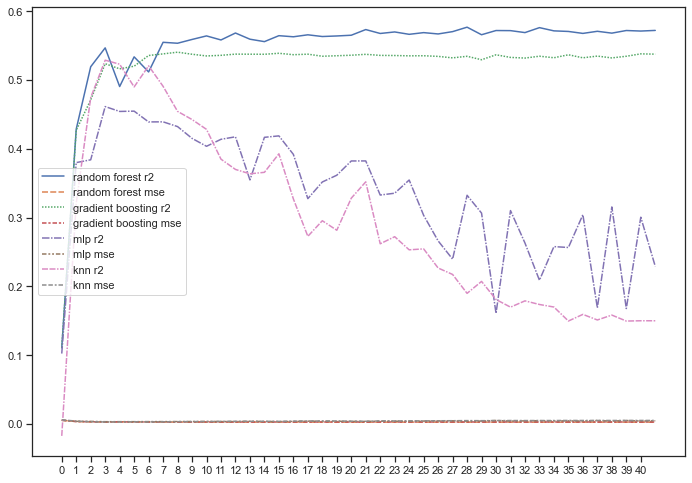

In [89]:
df1 = pd.DataFrame(randomForestMetrics, columns=["random forest r2", "random forest mse"])
df2 = pd.DataFrame(gradiendBoostingMetrics, columns=["gradient boosting r2", "gradient boosting mse"])
df3 = pd.DataFrame(mlpMetrics, columns=["mlp r2", "mlp mse"])
df4 = pd.DataFrame(knnMetrics, columns=["knn r2", "knn mse"])

g = sns.lineplot(data=pd.concat([df1,df2, df3, df4], axis=1))
g.set_xticks(range(0, 41))
print()

De acordo com o gráfico a acima iremos usar as 7 melhores features para treinar nosso modelos

In [90]:
X_new = SelectKBest(mutual_info_regression, k=7).fit_transform(X, y)
X_train, X_test, y_train, y_test = split_data(X_new, y)

## Seleção de hiperparametros

Iremos usar o framework Optuna para estimar os melhores hiperparametro rodando nosso modelos no conjunto de validação usando cross validation. As métricas que iremos utilizar para avaliar os modelos no conjunto de validação serão: r2 e MSE

In [174]:
def getMetrics(model):
    return cross_val_score(model, X_train, y_train, cv=10, scoring='r2').mean()

def optimizeRandomForest(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    model = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth, n_jobs=5, random_state=0)
    return getMetrics(model)

def optimizeGradientBoosting(trial):
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 0.4)
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    model = GradientBoostingRegressor(learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth, random_state=0)
    return getMetrics(model)

def optimizeMlp(trial):
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    n_layers = trial.suggest_int('n_layers', 1, 8)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('layer ' + str(i), 10, 100))
    
    model = MLPRegressor(hidden_layer_sizes=tuple(layers),
                                activation=activation, random_state=0)
    return getMetrics(model)

def optimizeKnn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 50)
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    return getMetrics(model)

n_trials=50

randomForestStudy = optuna.create_study(direction='maximize')
randomForestStudy.optimize(optimizeRandomForest, n_trials=n_trials)

gradientBoostingStudy = optuna.create_study(direction='maximize')
gradientBoostingStudy.optimize(optimizeGradientBoosting, n_trials=n_trials)

mlpStudy = optuna.create_study(direction='maximize')
mlpStudy.optimize(optimizeMlp, n_trials=n_trials)

knnStudy = optuna.create_study(direction='maximize')
knnStudy.optimize(optimizeKnn, n_trials=n_trials)

[I 2021-04-17 21:12:36,109] A new study created in memory with name: no-name-83e57737-02ea-4964-9b9c-62062b9e378f
[I 2021-04-17 21:12:39,942] Trial 0 finished with value: 0.5693668393738218 and parameters: {'n_estimators': 83, 'max_depth': 7}. Best is trial 0 with value: 0.5693668393738218.
[I 2021-04-17 21:12:42,286] Trial 1 finished with value: 0.587697068531351 and parameters: {'n_estimators': 75, 'max_depth': 9}. Best is trial 1 with value: 0.587697068531351.
[I 2021-04-17 21:12:42,933] Trial 2 finished with value: 0.5827503940271332 and parameters: {'n_estimators': 15, 'max_depth': 10}. Best is trial 1 with value: 0.587697068531351.
[I 2021-04-17 21:12:44,433] Trial 3 finished with value: 0.2499031759795165 and parameters: {'n_estimators': 97, 'max_depth': 2}. Best is trial 1 with value: 0.587697068531351.
[I 2021-04-17 21:12:46,155] Trial 4 finished with value: 0.5342410018752733 and parameters: {'n_estimators': 70, 'max_depth': 6}. Best is trial 1 with value: 0.587697068531351.


[I 2021-04-17 21:14:17,900] Trial 42 finished with value: 0.5912521295568991 and parameters: {'n_estimators': 97, 'max_depth': 10}. Best is trial 11 with value: 0.5912521295568991.
[I 2021-04-17 21:14:21,053] Trial 43 finished with value: 0.5906361575077879 and parameters: {'n_estimators': 95, 'max_depth': 10}. Best is trial 11 with value: 0.5912521295568991.
[I 2021-04-17 21:14:23,846] Trial 44 finished with value: 0.5883167328954781 and parameters: {'n_estimators': 90, 'max_depth': 9}. Best is trial 11 with value: 0.5912521295568991.
[I 2021-04-17 21:14:27,078] Trial 45 finished with value: 0.5912521295568991 and parameters: {'n_estimators': 97, 'max_depth': 10}. Best is trial 11 with value: 0.5912521295568991.
[I 2021-04-17 21:14:29,692] Trial 46 finished with value: 0.5882940198187468 and parameters: {'n_estimators': 85, 'max_depth': 9}. Best is trial 11 with value: 0.5912521295568991.
[I 2021-04-17 21:14:32,886] Trial 47 finished with value: 0.5909848989702171 and parameters: {'n_

[I 2021-04-17 21:17:05,721] Trial 29 finished with value: 0.37720687966658273 and parameters: {'learning_rate': 0.008420494152712177, 'n_estimators': 63, 'max_depth': 8}. Best is trial 25 with value: 0.5809904002514372.
[I 2021-04-17 21:17:14,059] Trial 30 finished with value: 0.5752041562224333 and parameters: {'learning_rate': 0.09192653983519009, 'n_estimators': 60, 'max_depth': 8}. Best is trial 25 with value: 0.5809904002514372.
[I 2021-04-17 21:17:20,709] Trial 31 finished with value: 0.5811245249048052 and parameters: {'learning_rate': 0.09091441711934321, 'n_estimators': 63, 'max_depth': 6}. Best is trial 31 with value: 0.5811245249048052.
[I 2021-04-17 21:17:27,634] Trial 32 finished with value: 0.5742125808525441 and parameters: {'learning_rate': 0.051761879198458115, 'n_estimators': 66, 'max_depth': 6}. Best is trial 31 with value: 0.5811245249048052.
[I 2021-04-17 21:17:35,451] Trial 33 finished with value: 0.5829226158342764 and parameters: {'learning_rate': 0.083185493110

[I 2021-04-17 21:22:53,043] Trial 12 finished with value: 0.4581967607356806 and parameters: {'activation': 'relu', 'n_layers': 8, 'layer 0': 42, 'layer 1': 13, 'layer 2': 41, 'layer 3': 100, 'layer 4': 41, 'layer 5': 11, 'layer 6': 11, 'layer 7': 16}. Best is trial 12 with value: 0.4581967607356806.
[I 2021-04-17 21:23:09,026] Trial 13 finished with value: 0.23702806080735334 and parameters: {'activation': 'relu', 'n_layers': 8, 'layer 0': 10, 'layer 1': 12, 'layer 2': 45, 'layer 3': 97, 'layer 4': 38, 'layer 5': 12, 'layer 6': 12, 'layer 7': 11}. Best is trial 12 with value: 0.4581967607356806.
[I 2021-04-17 21:23:23,320] Trial 14 finished with value: 0.3559467497902672 and parameters: {'activation': 'relu', 'n_layers': 5, 'layer 0': 35, 'layer 1': 26, 'layer 2': 40, 'layer 3': 100, 'layer 4': 39}. Best is trial 12 with value: 0.4581967607356806.
[I 2021-04-17 21:23:38,601] Trial 15 finished with value: -0.012327464387195074 and parameters: {'activation': 'logistic', 'n_layers': 7, '

[I 2021-04-17 21:31:28,417] Trial 40 finished with value: 0.17850539558464554 and parameters: {'activation': 'identity', 'n_layers': 7, 'layer 0': 32, 'layer 1': 60, 'layer 2': 25, 'layer 3': 55, 'layer 4': 44, 'layer 5': 14, 'layer 6': 10}. Best is trial 37 with value: 0.46538063812698277.
[I 2021-04-17 21:31:57,164] Trial 41 finished with value: 0.4614145188804753 and parameters: {'activation': 'relu', 'n_layers': 8, 'layer 0': 26, 'layer 1': 49, 'layer 2': 85, 'layer 3': 61, 'layer 4': 84, 'layer 5': 19, 'layer 6': 20, 'layer 7': 98}. Best is trial 37 with value: 0.46538063812698277.
[I 2021-04-17 21:32:31,870] Trial 42 finished with value: 0.4449572962655976 and parameters: {'activation': 'relu', 'n_layers': 8, 'layer 0': 43, 'layer 1': 48, 'layer 2': 81, 'layer 3': 63, 'layer 4': 99, 'layer 5': 19, 'layer 6': 19, 'layer 7': 100}. Best is trial 37 with value: 0.46538063812698277.
[I 2021-04-17 21:33:04,189] Trial 43 finished with value: 0.4484682366044341 and parameters: {'activati

[I 2021-04-17 21:36:08,791] Trial 29 finished with value: 0.26609275333157 and parameters: {'n_neighbors': 32}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:09,716] Trial 30 finished with value: 0.29403704618350535 and parameters: {'n_neighbors': 16}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:10,588] Trial 31 finished with value: 0.30869424920995747 and parameters: {'n_neighbors': 9}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:11,469] Trial 32 finished with value: 0.30799529380130924 and parameters: {'n_neighbors': 11}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:12,295] Trial 33 finished with value: 0.2522928271915095 and parameters: {'n_neighbors': 3}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:13,185] Trial 34 finished with value: 0.3012481964156507 and parameters: {'n_neighbors': 14}. Best is trial 17 with value: 0.3106557669058493.
[I 2021-04-17 21:36:14,

## Avaliando os modelos com os melhores hiperparametros

In [176]:
knn = KNeighborsRegressor(**knnStudy.best_trial.params)
randomForest = RandomForestRegressor(**randomForestStudy.best_trial.params, random_state=0)
mlp = MLPRegressor(**{'activation': 'tanh', 'hidden_layer_sizes': (17)}, random_state=0)
gradientBoosting = GradientBoostingRegressor(**gradientBoostingStudy.best_trial.params, random_state=0)

knn.fit(X_train, y_train)
randomForest.fit(X_train, y_train)
mlp.fit(X_train, y_train)
gradientBoosting.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.07842241021452004, max_depth=7,
                          n_estimators=69, random_state=0)

In [177]:
knnPredictions = knn.predict(X_test)
randomForestPredictions = randomForest.predict(X_test)
mlpPredictions = mlp.predict(X_test)
gradientBoostingPredictions = gradientBoosting.predict(X_test)

print('knn metrics')
print('R2', r2_score(y_test, knnPredictions))
print('MSE', mean_squared_error(y_test, knnPredictions))
print()

print('random forest metrics')
print('R2', r2_score(y_test, randomForestPredictions))
print('MSE', mean_squared_error(y_test, randomForestPredictions))
print()

print('mlp metrics')
print('R2', r2_score(y_test, mlpPredictions))
print('MSE', mean_squared_error(y_test, mlpPredictions))
print()


print('gradient boosting metrics')
print('R2', r2_score(y_test, gradientBoostingPredictions))
print('MSE', mean_squared_error(y_test, gradientBoostingPredictions))
print()

knn metrics
R2 0.3295016772438343
MSE 0.003911111769141838

random forest metrics
R2 0.5743113949378709
MSE 0.0024831019806346786

mlp metrics
R2 0.17318871873802388
MSE 0.004822907415652025

gradient boosting metrics
R2 0.5889415575513526
MSE 0.002397762168080284

